In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gp
import osmnx as ox
import sklearn

from itertools import combinations
from shapely.geometry import Point
from shapely.geometry import LineString
from pathlib import Path
from tqdm.auto import tqdm
from typing import Literal

In [161]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, ensemble

# 1. Анализ графа

In [3]:
def convert_gpd2graph(gdf, make_G_bidi = True, name='unamed'):
    """
    Converts shapefile to routable networkx graph.
    Based on https://gist.github.com/philippschw/a75f2436308c776d78057407eae76904

    Parameters
    ----------
    p : str, File path - allowed formats geojson and ESRI Shapefile and other formats Fiona can read and write
    make_G_bidi : bool, if True, assumes linestrings are bidirectional
    name : str, Optional name of graph

    Returns
    -------
    G : graph
    """
    gdf = gdf.copy()

    # shapefile needs to include minimal: geometry linestring and the length computed (e.g. in QGIS)
    if 'length' not in gdf.columns:
        raise Exception('Shapefile is invalid: length not in attributes:\n{}'.format(gdf.columns))

    if  not gdf.geometry.map(lambda x: type(x) ==  LineString).all():
        s_invalid_geo = gdf.geometry[gdf.geometry.map(lambda x: type(x) ==  LineString)]
        raise Exception('Shapefile is invalid: geometry not all linestring \n{}'.format(s_invalid_geo))

    # Compute the start- and end-position based on linestring
    gdf['Start_pos'] = gdf.geometry.apply(lambda x: x.coords[0])
    gdf['End_pos'] = gdf.geometry.apply(lambda x: x.coords[-1])

    # Create Series of unique nodes and their associated position
    s_points = pd.concat([gdf.Start_pos, gdf.End_pos]).reset_index(drop=True)
    s_points = s_points.drop_duplicates()
#     log('GeoDataFrame has {} elements (linestrings) and {} unique nodes'.format(len(gdf),len(s_points)))

    # Add index of start and end node of linestring to geopandas DataFrame
    df_points = pd.DataFrame(s_points, columns=['Start_pos'])
    df_points['FNODE_'] = df_points.index
    gdf = pd.merge(gdf, df_points, on='Start_pos', how='inner')

    df_points = pd.DataFrame(s_points, columns=['End_pos'])
    df_points['TNODE_'] = df_points.index
    gdf = pd.merge(gdf, df_points, on='End_pos', how='inner')

    # Bring nodes and their position in form needed for osmnx (give arbitrary osmid (index) despite not osm file)
    df_points.columns = ['pos', 'osmid']
    df_points[['x', 'y']] = df_points['pos'].apply(pd.Series)
    df_node_xy = df_points.drop('pos', axis=1)

    # Create Graph Object
    G = nx.MultiDiGraph(name=name, crs=gdf.crs)

    # Add nodes to graph
    for node, data in df_node_xy.T.to_dict().items():
        G.add_node(node, **data)

    # Add edges to graph
    for i, row  in gdf.iterrows():
        dict_row  = row.to_dict()
        if 'geometry' in dict_row: del dict_row['geometry']
        G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)

    if make_G_bidi:
        gdf.rename(columns={'Start_pos': 'End_pos',
                   'End_pos': 'Start_pos',
                   'FNODE_': 'TNODE_',
                   'TNODE_': 'FNODE_', }, inplace=True)

        # Add edges to graph
        for i, row  in gdf.iterrows():
            dict_row  = row.to_dict()
            if 'geometry' in dict_row: del dict_row['geometry']
            G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)

    return G

In [76]:
class RailwayGraph:
    def __init__(
            self,
            routes: str | Path | gp.GeoDataFrame | nx.Graph,
            stations: str | Path | gp.GeoDataFrame | dict,
            directions: list[tuple[str, str]] = None,
    ):
        routes_geo_crs: str = None
        # Загрузим пути жд дороги из shp
        if isinstance(routes, (str, Path)):
            routes = Path(routes)
            # Загрузим GeoDataFrame
            routes: gp.GeoDataFrame = gp.read_file(routes)
        if isinstance(routes, gp.GeoDataFrame):
            # Запомним кодировку точек
            routes_geo_crs = routes.crs
            # Преобразуем в граф:
            routes: gp.GeoDataFrame = convert_gpd2graph(routes, make_G_bidi=True)
        if not isinstance(routes, nx.Graph):
            raise ValueError("'routes' is not file, GeoDataFrame or Graph")
        if isinstance(routes, nx.MultiDiGraph):
            # Удалим параллельные связи между узлами (избыточные)
            routes = ox.convert.to_digraph(routes, weight='length')
            routes = nx.MultiDiGraph(routes)

        # Загрузим станции из shp
        if isinstance(stations, (str, Path)):
            stations = Path(stations)
            # Загрузим GeoDataFrame
            stations: gp.GeoDataFrame = gp.read_file(stations)
        if isinstance(stations, gp.GeoDataFrame):
            # Заменим кодировку точек
            if routes_geo_crs:
                stations = stations.to_crs(routes_geo_crs)
            # Преобразуем станции в словарь
            stations = {
                key: (val.x, val.y) for key, val in zip(stations.name, stations.geometry)
            }
        if not isinstance(stations, dict):
            raise ValueError("'routes' is not file, GeoDataFrame or dict")

        self.routes_graph: nx.Graph = routes
        self._id_2_route_map = list(self.routes_graph)
        self._route_2_id_map = {val: idx for idx, val in enumerate(self._id_2_route_map)}
        self.station_2_point_map: dict[str, tuple[int, int]] = stations

        if directions is not None:
            self._filter_routes(directions)

    def _filter_routes(self, directions: list[tuple[str, str]]):
        unusage_edges_idx = set(range(len(self.routes_graph.edges)))
        for src, dst in tqdm(
                directions,
                desc='Finding routes between stations'
        ):
            route_edges_idx = self.find_route(src, dst)
            unusage_edges_idx -= set(route_edges_idx)

        unusage_edges_point = []

        for i, (u, v, _) in enumerate(self.routes_graph.edges):
            if i in unusage_edges_idx:
                unusage_edges_point.append((u, v))

        self.routes_graph.remove_edges_from(unusage_edges_point)

    def find_route(self, src_station: str, dst_station: str) -> list[int]:
        src_point = self.station_2_point_map[src_station]
        dst_point = self.station_2_point_map[dst_station]

        src_node = ox.nearest_nodes(self.routes_graph, *src_point)
        dst_node = ox.nearest_nodes(self.routes_graph, *dst_point)

        route = ox.shortest_path(self.routes_graph, src_node, dst_node, weight="length")

        return route

    def plot_route(self, route: list[int]):
        fig, ax = ox.plot_graph_route(
            self.routes_graph,
            route,
            route_color="y",
            route_linewidth=6,
            node_size=0
        )
        plt.show()

    def get_route_geodata(self, route: list[int]) -> gp.GeoDataFrame:
        return ox.routing.route_to_gdf(self.routes_graph, route)

    @property
    def stations(self) -> list[str]:
        return list(self.station_2_point_map.keys())

    @property
    def nodes(self):
        return self.routes_graph.nodes

    @property
    def edges(self):
        return self.routes_graph.edges

In [5]:
stations_geo_df: gp.GeoDataFrame = gp.read_file('../data/stations_v2/stationsv2.shp')
stations_geo_df

,name,geometry
0,Бекасово-Центральное,POINT (36.88475 55.40511)
1,Яничкино,POINT (37.85962 55.65347)
2,Красное,POINT (31.03734 54.68266)
3,Петушки,POINT (39.46251 55.92466)
4,Тула-Вяземская,POINT (37.62872 54.20917)
...,...,...
59,Белгород,POINT (36.60598 50.59303)
60,Балашиха,POINT (37.94846 55.80955)
61,Льгов-Киевский,POINT (35.26924 51.63673)
62,Присады,POINT (37.81096 54.11987)


In [6]:
extra_stations_geo_df = gp.GeoDataFrame(
    {
        'name': [
            'Александров-2',
            'Брянск-Льговский',
            'Люблино-Сортировочное',
            'Орехово-Зуево',
            'Стенькино-I',
            'Тула 2'
        ],
        'geometry': [
            Point(38.6913863, 56.3721772),
            Point(34.4094874, 53.2135764),
            Point(37.7300731, 55.6715844),
            Point(38.9756838, 55.7953125),
            Point(39.7378679, 54.5343002),
            Point(37.5567752, 54.1693498),
        ]
    },
    crs='EPSG:4326'
)
extra_stations_geo_df

,name,geometry
0,Александров-2,POINT (38.69139 56.37218)
1,Брянск-Льговский,POINT (34.40949 53.21358)
2,Люблино-Сортировочное,POINT (37.73007 55.67158)
3,Орехово-Зуево,POINT (38.97568 55.79531)
4,Стенькино-I,POINT (39.73787 54.5343)
5,Тула 2,POINT (37.55678 54.16935)


In [7]:
full_stations_geo_df = pd.concat(
    [
        stations_geo_df,
        extra_stations_geo_df
    ],
    axis=0
)
full_stations_geo_df

,name,geometry
0,Бекасово-Центральное,POINT (36.88475 55.40511)
1,Яничкино,POINT (37.85962 55.65347)
2,Красное,POINT (31.03734 54.68266)
3,Петушки,POINT (39.46251 55.92466)
4,Тула-Вяземская,POINT (37.62872 54.20917)
...,...,...
1,Брянск-Льговский,POINT (34.40949 53.21358)
2,Люблино-Сортировочное,POINT (37.73007 55.67158)
3,Орехово-Зуево,POINT (38.97568 55.79531)
4,Стенькино-I,POINT (39.73787 54.5343)


In [82]:
railway_graph = RailwayGraph(
    '../data/all_routes_v2/all_routes_v2.shp',
    full_stations_geo_df,
    # directions=combinations(full_stations_geo_df.name.to_list(), 2)
)

In [83]:
len(railway_graph.nodes)

7386

In [84]:
len(railway_graph.edges)

16586

Route size: 169
Route length: 491487.4970078722


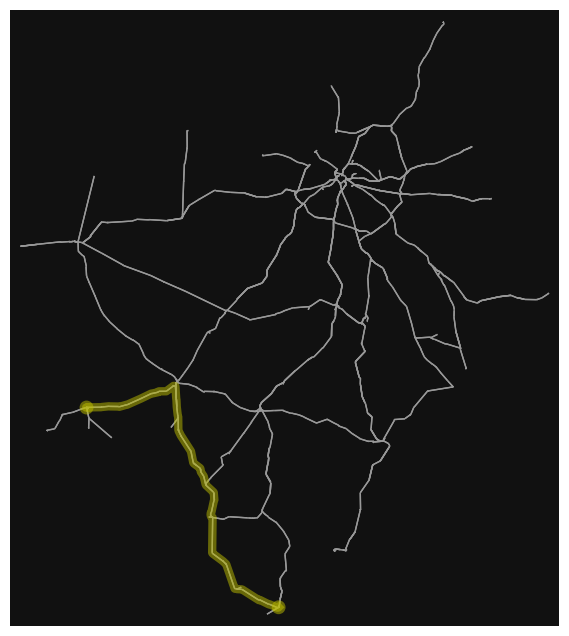

In [85]:
test_route = railway_graph.find_route('Белгород', 'Унеча')
print('Route size:', len(test_route))
test_route_len = railway_graph.get_route_geodata(test_route).length.sum()
print('Route length:', test_route_len)
railway_graph.plot_route(
    test_route
)

# Загрузка данных

In [12]:
train_df = pd.read_csv('../data/dataset_external.csv')
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [13]:
test_df = pd.read_csv('../data/dataset_internal.csv')
test_df

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


# 1. Подход 1: Длина маршрута

In [14]:
class RailwayGraphLength(sklearn.base.TransformerMixin):
    def __init__(
            self,
            graph: RailwayGraph,
            verbose: bool = True
    ):
        self._graph = graph
        self._vebose = verbose

    def fit(self, data: pd.DataFrame, y=None):
        return self

    def transform(self, data: pd.DataFrame, y=None):
        num_samples = len(data['route_start'])
        route_len = np.zeros((num_samples), dtype=np.uint32)

        available_stations = set(self._graph.stations)
        data_iter = zip(data['route_start'], data['route_end'])
        if self._vebose:
            data_iter = tqdm(data_iter, total=num_samples, desc='Transform data [onehot + length]')
        for i, (src, dst) in enumerate(data_iter):
            for name in (src, dst):
                if name not in available_stations:
                    raise ValueError(f"'{name}' not found in available stations")
            route = self._graph.find_route(src, dst)
            length = self._graph.get_route_geodata(route).length.sum()
            route_len[i] = length

        length_data = pd.DataFrame(
            route_len[:, None],
            columns=['length']
        )

        return length_data

In [15]:
rw_graph_length_transform = RailwayGraphLength(railway_graph)

In [16]:
prepared_train_df = train_df.copy()
prepared_train_df = pd.concat(
    [
        prepared_train_df[['index', 'value']],
        rw_graph_length_transform.fit_transform(prepared_train_df),
    ],
    axis=1
)
prepared_train_df.sample(10)

100%|██████████| 1519/1519 [07:04<00:00,  3.58it/s]


,index,value,length
828,2051,7.300000,373564
172,1389,4.233333,393506
76,427,0.966667,18074
359,1443,12.100000,217976
692,2189,10.116667,245662
333,1439,11.750000,465620
1281,5041,9.616667,367165
530,11775,9.550000,94183
1114,893,5.766667,249561
1023,12420,15.550000,118599


In [17]:
prepared_test_df = test_df.copy()
prepared_test_df = pd.concat(
    [
        prepared_test_df[['index']],
        rw_graph_length_transform.transform(prepared_test_df),
    ],
    axis=1
)
prepared_test_df.sample(10)

100%|██████████| 1519/1519 [07:01<00:00,  3.61it/s]


,index,length
746,8772,366906
774,2529,37787
421,4953,767731
1054,3205,248664
383,970,375406
130,3864,603483
795,4888,273364
318,12990,454966
182,1950,396580
176,504,202166


In [18]:
prepared_train_df.to_csv('prepared_train_length_dataset.csv', index=False)
prepared_test_df.to_csv('prepared_test_length_dataset.csv', index=False)

## Обучение модели

In [19]:
prepared_train_df = pd.read_csv('prepared_train_length_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_length_dataset.csv')

In [20]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value

In [21]:
X

,length
0,20435
1,851505
2,194988
3,507888
4,669033
...,...
1514,219884
1515,403282
1516,391259
1517,318381


In [22]:
models = [
    linear_model.LinearRegression(),
    linear_model.BayesianRidge(),
]
scores = []

for model in tqdm(models):
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)

compare_table = pd.DataFrame(
    {
        "name": [str(m) for m in models],
        "MAE": [- values.mean() for values in scores]
    }
)
compare_table

100%|██████████| 2/2 [00:00<00:00, 58.70it/s]


,name,MAE
0,LinearRegression(),2.956264
1,BayesianRidge(),2.956264


# 2. Подход 2: OneHot

In [90]:
class RailwayGraphOneHot(sklearn.base.TransformerMixin):
    def __init__(
            self,
            graph: RailwayGraph,
            verbose: bool = True,
            undirectional: bool = False,
    ):
        self._graph = graph
        self._vebose = verbose
        self._edge_2_id_map = {}
        self._fit = False
        self._undirectional = undirectional

    def fit(self, data: pd.DataFrame, y=None):
        self._fit = True
        return self

    def transform(self, data: pd.DataFrame, y=None):
        if not self._fit and not self._edge_2_id_map:
            raise ValueError('run fit before transform')

        num_samples = len(data['route_start'])
        if self._fit:
            oh_route = np.zeros((num_samples, len(self._graph.edges)), dtype=bool)
        else:
            oh_route = np.zeros((num_samples, len(self._edge_2_id_map)), dtype=bool)

        # Получим допустимые для кодирования станции
        available_stations = set(self._graph.stations)
        # Пройдёмся по всем маршрутам
        data_iter = zip(data['route_start'], data['route_end'])
        if self._vebose:
            data_iter = tqdm(data_iter, total=num_samples)
        for i, (src, dst) in enumerate(data_iter):
            # Проверим на то, что станции доступны для обработки
            for name in (src, dst):
                if name not in available_stations:
                    raise ValueError(f"'{name}' not found in available stations")
            # Найдём кратчайший маршрут между станциями
            route = self._graph.find_route(src, dst)
            edges_info = self._graph.get_route_geodata(route)
            for u, v, k in edges_info.index:
                if self._undirectional and u > v:
                    u, v = v, u
                edge_idx = (u, v, k)
                if edge_idx not in self._edge_2_id_map:
                    if self._fit:
                        self._edge_2_id_map[edge_idx] = len(self._edge_2_id_map)
                    else:
                        raise ValueError(f"Edge with index '{edge_idx}' not found in fit dataset")

                oh_route[i][self._edge_2_id_map[edge_idx]] = 1

        if self._fit:
            oh_route = oh_route[:, :len(self._edge_2_id_map)]

        oh_data = pd.DataFrame(
            oh_route,
            columns=(f'route_{i}' for i in range(oh_route.shape[1]))
        )

        self._fit = False

        return oh_data

In [92]:
rw_graph_onehot = RailwayGraphOneHot(railway_graph, undirectional=True)

In [93]:
prepared_train_df = train_df.copy()
prepared_train_df = pd.concat(
    [
        prepared_train_df[['index', 'value']],
        rw_graph_onehot.fit_transform(prepared_train_df),
    ],
    axis=1
)
prepared_train_df.sample(10)

100%|██████████| 1519/1519 [03:16<00:00,  7.74it/s]


,index,value,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,...,route_3809,route_3810,route_3811,route_3812,route_3813,route_3814,route_3815,route_3816,route_3817,route_3818
641,140,8.700000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1261,2777,10.083333,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
590,957,23.366667,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1040,12717,9.383333,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1337,2737,9.183333,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
130,2183,8.133333,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
738,6513,9.533333,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,1198,4.150000,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
407,3701,7.450000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1436,1242,5.616667,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [94]:
prepared_test_df = test_df.copy()
prepared_test_df = pd.concat(
    [
        prepared_test_df[['index']],
        rw_graph_onehot.transform(prepared_test_df),
    ],
    axis=1
)
prepared_test_df.sample(10)

 14%|█▎        | 208/1519 [00:28<02:59,  7.32it/s]


ValueError: Edge with index '(8850, 8943, 0)' not found in fit dataset

In [44]:
prepared_train_df.to_csv('prepared_train_oh_dataset.csv', index=False)
prepared_test_df.to_csv('prepared_test_oh_dataset.csv', index=False)

## Обучение модели

In [45]:
prepared_train_df = pd.read_csv('prepared_train_oh_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_oh_dataset.csv')

In [46]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value

In [47]:
X

,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,route_8,route_9,...,route_7598,route_7599,route_7600,route_7601,route_7602,route_7603,route_7604,route_7605,route_7606,route_7607
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1516,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1517,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
models = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge()
]
scores = []

for model in tqdm(models):
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)

compare_table = pd.DataFrame(
    {
        "name": [str(m) for m in models],
        "MAE": [- values.mean() for values in scores]
    }
)
compare_table

100%|██████████| 6/6 [00:23<00:00,  3.93s/it]


,name,MAE
0,LinearRegression(),1.276186e+11
1,Ridge(),1.465347e+00
2,Lasso(),3.617129e+00
3,ElasticNet(),3.565178e+00
4,SGDRegressor(),1.551696e+00
5,BayesianRidge(),1.559372e+00


# 3. Подход 3: "OneHot" на расстоянии

In [20]:
class RailwayGraphLengthHot(sklearn.base.TransformerMixin):
    def __init__(
            self,
            graph: RailwayGraph,
            verbose: bool = True
    ):
        self._graph = graph
        self._vebose = verbose
        self._edge_2_id_map = {}
        self._fit = False

    def fit(self, data: pd.DataFrame, y=None):
        self._fit = True
        return self

    def transform(self, data: pd.DataFrame, y=None):
        if not self._fit and not self._edge_2_id_map:
            raise ValueError('run fit before transform')

        num_samples = len(data['route_start'])
        if self._fit:
            oh_route = np.zeros((num_samples, len(self._graph.edges)), dtype=np.uint32)
        else:
            oh_route = np.zeros((num_samples, len(self._edge_2_id_map)), dtype=np.uint32)

        # Получим допустимые для кодирования станции
        available_stations = set(self._graph.stations)
        # Пройдёмся по всем маршрутам
        data_iter = zip(data['route_start'], data['route_end'])
        if self._vebose:
            data_iter = tqdm(data_iter, total=num_samples)
        for i, (src, dst) in enumerate(data_iter):
            # Проверим на то, что станции доступны для обработки
            for name in (src, dst):
                if name not in available_stations:
                    raise ValueError(f"'{name}' not found in available stations")
            # Найдём кратчайший маршрут между станциями
            route = self._graph.find_route(src, dst)
            edges_info = self._graph.get_route_geodata(route)
            for (u, v, k), edge_length in zip(edges_info.index, edges_info.length):
                edge_idx = (u, v, k)
                if edge_idx not in self._edge_2_id_map:
                    if self._fit:
                        self._edge_2_id_map[edge_idx] = len(self._edge_2_id_map)
                    else:
                        raise ValueError(f"Edge with index '{edge_idx}' not found in fit dataset")

                oh_route[i][self._edge_2_id_map[edge_idx]] = edge_length

        if self._fit:
            oh_route = oh_route[:, :len(self._edge_2_id_map)]

        oh_data = pd.DataFrame(
            oh_route,
            columns=(f'route_{i}' for i in range(oh_route.shape[1]))
        )

        self._fit = False

        return oh_data

In [21]:
rw_graph_length_hot = RailwayGraphLengthHot(railway_graph)

In [22]:
prepared_train_df = train_df.copy()
prepared_train_df = pd.concat(
    [
        prepared_train_df[['index', 'value']],
        rw_graph_length_hot.fit_transform(prepared_train_df),
    ],
    axis=1
)
prepared_train_df.sample(10)

100%|██████████| 1519/1519 [03:06<00:00,  8.16it/s]


,index,value,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,...,route_7598,route_7599,route_7600,route_7601,route_7602,route_7603,route_7604,route_7605,route_7606,route_7607
630,2376,11.366667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463,31,8.283333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,174,11.483333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,186,8.033333,0,0,0,0,0,0,832,200,...,0,0,0,0,0,0,0,0,0,0
351,1069,16.716667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,3073,6.950000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
861,9761,14.533333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,3568,5.866667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177,1211,15.466667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410,451,10.583333,464,208,19,45,215,94,832,200,...,0,0,0,0,0,0,0,0,0,0


In [23]:
prepared_test_df = test_df.copy()
prepared_test_df = pd.concat(
    [
        prepared_test_df[['index']],
        rw_graph_length_hot.transform(prepared_test_df),
    ],
    axis=1
)
prepared_test_df.sample(10)

100%|██████████| 1519/1519 [03:13<00:00,  7.85it/s]


,index,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,route_8,...,route_7634,route_7635,route_7636,route_7637,route_7638,route_7639,route_7640,route_7641,route_7642,route_7643
13,3811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
670,4445,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
687,722,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1155,1599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,1217,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,781,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1191,5968,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,1251,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
811,4486,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
prepared_train_df.to_csv('prepared_train_length_oh_dataset.csv', index=False)
prepared_test_df.to_csv('prepared_test_length_oh_dataset.csv', index=False)

## Обучение модели

In [25]:
prepared_train_df = pd.read_csv('prepared_train_length_oh_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_length_oh_dataset.csv')

In [26]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value

In [27]:
X

,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,route_8,route_9,...,route_7598,route_7599,route_7600,route_7601,route_7602,route_7603,route_7604,route_7605,route_7606,route_7607
0,464,208,19,45,215,94,832,200,73,88,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
models = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge()
]
scores = []

for model in tqdm(models):
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)

compare_table = pd.DataFrame(
    {
        "name": [str(m) for m in models],
        "MAE": [- values.mean() for values in scores]
    }
)
compare_table

 33%|███▎      | 2/6 [00:06<00:12,  3.02s/it]E:\Anaconda\envs\RZD_HACKATON\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.978e+02, tolerance: 2.550e+00
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\envs\RZD_HACKATON\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e+02, tolerance: 2.599e+00
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\envs\RZD_HACKATON\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

,name,MAE
0,LinearRegression(),1.067698e+10
1,Ridge(),1.486008e+00
2,Lasso(),1.524948e+00
3,ElasticNet(),1.499056e+00
4,SGDRegressor(),1.172498e+18
5,BayesianRidge(),1.901398e+00


# 4. Подход 4: "OneHot" пути + узлы

In [86]:
class RailwayGraphEdgeAndNodesOneHot(sklearn.base.TransformerMixin):
    def __init__(
            self,
            graph: RailwayGraph,
            verbose: bool = True,
            undirectional: bool = False,
    ):
        self._graph = graph
        self._vebose = verbose
        self._node_2_id_map = {}
        self._edge_2_id_map = {}
        self._fit = False
        self._undirectional = undirectional

    def fit(self, data: pd.DataFrame, y=None):
        self._fit = True
        return self

    def transform(self, data: pd.DataFrame, y=None):
        if not self._fit and not self._edge_2_id_map:
            raise ValueError('run fit before transform')

        num_samples = len(data['route_start'])
        if self._fit:
            nodes_oh_route = np.zeros((num_samples, len(self._graph.nodes)), dtype=bool)
            edges_oh_route = np.zeros((num_samples, len(self._graph.edges)), dtype=bool)
        else:
            nodes_oh_route = np.zeros((num_samples, len(self._node_2_id_map)), dtype=bool)
            edges_oh_route = np.zeros((num_samples, len(self._edge_2_id_map)), dtype=bool)

        # Получим допустимые для кодирования станции
        available_stations = set(self._graph.stations)
        # Пройдёмся по всем маршрутам
        data_iter = zip(data['route_start'], data['route_end'])
        if self._vebose:
            data_iter = tqdm(data_iter, total=num_samples)
        for i, (src, dst) in enumerate(data_iter):
            # Проверим на то, что станции доступны для обработки
            for name in (src, dst):
                if name not in available_stations:
                    raise ValueError(f"'{name}' not found in available stations")
            # Найдём кратчайший маршрут между станциями
            route = self._graph.find_route(src, dst)
            # Внесём узлы маршрута в кодировку
            for node_idx in route:
                if node_idx not in self._node_2_id_map:
                    if self._fit:
                        self._node_2_id_map[node_idx] = len(self._node_2_id_map)
                    else:
                        raise ValueError(f"Node with index '{node_idx}' not found in fit dataset")

                nodes_oh_route[i][self._node_2_id_map[node_idx]] = True
            # Получим информацию о рёбрах
            edges_info = self._graph.get_route_geodata(route)
            # Внесём рёбра маршрута в кодировку
            for u, v, k in edges_info.index:
                if self._undirectional and u > v:
                    u, v = v, u
                edge_idx = (u, v, k)
                if edge_idx not in self._edge_2_id_map:
                    if self._fit:
                        self._edge_2_id_map[edge_idx] = len(self._edge_2_id_map)
                    else:
                        raise ValueError(f"Edge with index '{edge_idx}' not found in fit dataset")

                edges_oh_route[i][self._edge_2_id_map[edge_idx]] = True

        if self._fit:
            nodes_oh_route = edges_oh_route[:, :len(self._node_2_id_map)]
            edges_oh_route = edges_oh_route[:, :len(self._edge_2_id_map)]

        nodes_oh_data = pd.DataFrame(
            nodes_oh_route,
            columns=(f'node_{i}' for i in range(nodes_oh_route.shape[1]))
        )
        edges_oh_data = pd.DataFrame(
            edges_oh_route,
            columns=(f'route_{i}' for i in range(edges_oh_route.shape[1]))
        )
        oh_data = pd.concat([nodes_oh_data, edges_oh_data], axis=1)

        self._fit = False

        return oh_data

In [87]:
rw_graph_ne_hot = RailwayGraphEdgeAndNodesOneHot(railway_graph, undirectional=True)

In [88]:
prepared_train_df = train_df.copy()
prepared_train_df = pd.concat(
    [
        prepared_train_df[['index', 'value']],
        rw_graph_ne_hot.fit_transform(prepared_train_df),
    ],
    axis=1
)
prepared_train_df.sample(10)

100%|██████████| 1519/1519 [03:20<00:00,  7.57it/s]


,index,value,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,...,route_3809,route_3810,route_3811,route_3812,route_3813,route_3814,route_3815,route_3816,route_3817,route_3818
731,577,6.383333,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
117,327,6.050000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
724,1038,10.466667,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
438,2487,8.900000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
760,60,3.916667,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
848,9523,6.633333,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1348,2476,12.533333,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
720,1093,12.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
866,2905,11.300000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1440,4349,10.900000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [89]:
prepared_test_df = test_df.copy()
prepared_test_df = pd.concat(
    [
        prepared_test_df[['index']],
        rw_graph_ne_hot.transform(prepared_test_df),
    ],
    axis=1
)
prepared_test_df.sample(10)

 14%|█▎        | 208/1519 [00:27<02:54,  7.50it/s]


ValueError: Node with index '8943' not found in fit dataset

In [ ]:
prepared_train_df.to_csv('prepared_train_ne_oh_dataset.csv', index=False)
prepared_test_df.to_csv('prepared_test_ne_oh_dataset.csv', index=False)

## Обучение модели

In [35]:
prepared_train_df = pd.read_csv('prepared_train_ne_oh_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_ne_oh_dataset.csv')

In [36]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value

In [37]:
X

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,route_7598,route_7599,route_7600,route_7601,route_7602,route_7603,route_7604,route_7605,route_7606,route_7607
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1516,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1517,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
models = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.Ridge(positive=True),
]
scores = []

for model in tqdm(models):
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)

compare_table = pd.DataFrame(
    {
        "name": [str(m) for m in models],
        "MAE": [- values.mean() for values in scores]
    }
)
compare_table

100%|██████████| 7/7 [00:37<00:00,  5.33s/it]


,name,MAE
0,LinearRegression(),7.648903e+10
1,Ridge(),1.465196e+00
2,Lasso(),3.617129e+00
3,ElasticNet(),3.558992e+00
4,SGDRegressor(),1.590322e+00
5,BayesianRidge(),1.564293e+00
6,Ridge(positive=True),1.529263e+00


# 5. Подход 5: Length + OneHot

In [103]:
class RailwayGraphOneHotWithLength(sklearn.base.TransformerMixin):
    def __init__(
            self,
            graph: RailwayGraph,
            verbose: bool = True,
            undirectional: bool = False,
            no_found: Literal["skip", "error"] = "error"
    ):
        self._graph = graph
        self._vebose = verbose
        self._edge_2_id_map = {}
        self._fit = False
        self._undirectional = undirectional
        self._no_found = no_found

    def fit(self, data: pd.DataFrame, y=None):
        self._fit = True
        return self

    def transform(self, data: pd.DataFrame, y=None):
        if not self._fit and not self._edge_2_id_map:
            raise ValueError('run fit before transform')

        num_samples = len(data['route_start'])
        len_route = np.zeros(num_samples, dtype=np.uint32)
        if self._fit:
            oh_route = np.zeros((num_samples, len(self._graph.edges)), dtype=bool)
        else:
            oh_route = np.zeros((num_samples, len(self._edge_2_id_map)), dtype=bool)

        # Получим допустимые для кодирования станции
        available_stations = set(self._graph.stations)
        # Пройдёмся по всем маршрутам
        data_iter = zip(data['route_start'], data['route_end'])
        if self._vebose:
            data_iter = tqdm(data_iter, total=num_samples)
        for i, (src, dst) in enumerate(data_iter):
            # Проверим на то, что станции доступны для обработки
            for name in (src, dst):
                if name not in available_stations:
                    raise ValueError(f"'{name}' not found in available stations")
            # Найдём кратчайший маршрут между станциями
            route = self._graph.find_route(src, dst)
            edges_info = self._graph.get_route_geodata(route)
            for u, v, k in edges_info.index:
                if self._undirectional and u > v:
                    u, v = v, u
                edge_idx = (u, v, k)
                if edge_idx not in self._edge_2_id_map:
                    if self._fit:
                        self._edge_2_id_map[edge_idx] = len(self._edge_2_id_map)
                    elif self._no_found == "error":
                        raise ValueError(f"Edge with index '{edge_idx}' not found in fit dataset")
                    else:
                        continue

                oh_route[i][self._edge_2_id_map[edge_idx]] = True
            len_route[i] = edges_info.length.sum()

        if self._fit:
            oh_route = oh_route[:, :len(self._edge_2_id_map)]

        len_data = pd.DataFrame(
            len_route[:, None],
            columns=['length'],
        )
        oh_data = pd.DataFrame(
            oh_route,
            columns=(f'route_{i}' for i in range(oh_route.shape[1]))
        )
        data = pd.concat([len_data, oh_data], axis=1)

        self._fit = False

        return data

In [104]:
rw_graph_onehot_with_len = RailwayGraphOneHotWithLength(railway_graph, undirectional=True, no_found="skip")

In [105]:
prepared_train_df = train_df.copy()
prepared_train_df = pd.concat(
    [
        prepared_train_df[['index', 'value']],
        rw_graph_onehot_with_len.fit_transform(prepared_train_df),
    ],
    axis=1
)
prepared_train_df.sample(10)

100%|██████████| 1519/1519 [03:13<00:00,  7.84it/s]


,index,value,length,route_0,route_1,route_2,route_3,route_4,route_5,route_6,...,route_3809,route_3810,route_3811,route_3812,route_3813,route_3814,route_3815,route_3816,route_3817,route_3818
823,3581,11.833333,370719,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
852,997,6.783333,129696,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1060,1759,8.516667,181532,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
748,1446,14.750000,378347,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
202,7103,11.016667,376145,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
278,793,11.083333,446394,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1166,12198,12.333333,391718,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
270,954,16.033333,708460,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
597,3027,6.533333,37390,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1215,8099,6.100000,207643,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [106]:
prepared_test_df = test_df.copy()
prepared_test_df = pd.concat(
    [
        prepared_test_df[['index']],
        rw_graph_onehot_with_len.transform(prepared_test_df),
    ],
    axis=1
)
prepared_test_df.sample(10)

100%|██████████| 1519/1519 [03:18<00:00,  7.65it/s]


,index,length,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,...,route_3809,route_3810,route_3811,route_3812,route_3813,route_3814,route_3815,route_3816,route_3817,route_3818
30,1455,851762,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1372,4108,208200,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
602,4720,678564,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
234,883,250809,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1326,1352,193136,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
359,2375,780708,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
802,4154,235084,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1342,2267,410691,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1268,4215,502093,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1504,1438,531498,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [107]:
prepared_train_df.to_csv('prepared_train_oh_with_len_dataset.csv', index=False)
prepared_test_df.to_csv('prepared_test_oh_with_len_dataset.csv', index=False)

## Обучение модели

In [108]:
prepared_train_df = pd.read_csv('prepared_train_oh_with_len_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_oh_with_len_dataset.csv')

In [109]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value

In [110]:
X

,length,route_0,route_1,route_2,route_3,route_4,route_5,route_6,route_7,route_8,...,route_3809,route_3810,route_3811,route_3812,route_3813,route_3814,route_3815,route_3816,route_3817,route_3818
0,20435,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,851505,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,194988,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,507888,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,669033,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,219884,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1515,403282,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1516,391259,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1517,318381,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [176]:
models = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(),
    linear_model.SGDRegressor(),
    ensemble.GradientBoostingRegressor(n_estimators=300),
    ensemble.GradientBoostingRegressor(n_estimators=500),
    ensemble.GradientBoostingRegressor(n_estimators=700),
]
scores = []

for model in tqdm(models):
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)

compare_table = pd.DataFrame(
    {
        "name": [str(m) for m in models],
        "MAE": [- values.mean() for values in scores]
    }
)
compare_table

100%|██████████| 7/7 [04:56<00:00, 42.31s/it]


,name,MAE
0,LinearRegression(),2.379706e+01
1,Ridge(),1.342980e+00
2,Lasso(),2.956264e+00
3,SGDRegressor(),3.022909e+19
4,GradientBoostingRegressor(n_estimators=300),1.027983e+00
5,GradientBoostingRegressor(n_estimators=500),8.317390e-01
6,GradientBoostingRegressor(n_estimators=700),7.209938e-01


In [114]:
best_model = models[compare_table.MAE.argmin()].fit(X, y)
# best_model = models[-1].fit(X, y)

Посмотрим на распределение весов у самой лучшей модели

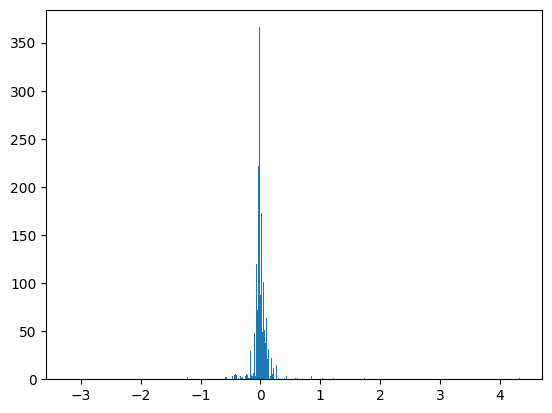

In [115]:
plt.hist(best_model.coef_, bins=1000)
plt.show()

# Предсказание

In [178]:
prepared_train_df = pd.read_csv('prepared_train_oh_with_len_dataset.csv')
prepared_test_df = pd.read_csv('prepared_test_oh_with_len_dataset.csv')

In [179]:
X, y = prepared_train_df.iloc[:, 2:], prepared_train_df.value
test_X = prepared_test_df.iloc[:, 1:]

In [180]:
best_model = ensemble.GradientBoostingRegressor(n_estimators=700)
best_model.fit(X, y)

GradientBoostingRegressor(n_estimators=700)

In [181]:
from sklearn import metrics

In [182]:
train_pred = best_model.predict(X)
print('MAE:', metrics.mean_absolute_error(y, train_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y, train_pred))

MAE: 0.38994436981060726
MAPE: 0.04713798614567302


In [183]:
test_pred = best_model.predict(test_X)

In [184]:
submit_df = test_df.copy()
submit_df['value_predict'] = test_pred
submit_df

,index,route_start,route_end,value_predict
0,2623,Вязьма,Щёлково,11.993191
1,4413,Аэропорт,Лесок,11.606902
2,480,Узуново,Малоярославец,10.546169
3,4409,Серпухов,Лесок,10.322626
4,9286,Кунцево II,Петушки,10.757859
...,...,...,...,...
1514,1676,Елец,Перово,10.294554
1515,8047,Зелёный Бор,Вековка,7.053797
1516,37,Москва-Товарная-Смоленская,Курбакинская,13.987824
1517,1179,Смоленск-Сортировочный,Владимир,8.157005


In [185]:
submit_df.to_csv('../submition_boost_700_oh_with_len.csv', index=False)

In [188]:
pd.DataFrame(
    {
        "transform": ["Length", "Edge OneHot", "Edge Length", "Edge and Node OneHot", "Edge OneHot + Length", "Edge OneHot + Length"],
        "model": ['LinearRegression'] + ['Ridge'] * 4 + ['GradientBoostingRegressor(n_estimators=700)'],
        "MAE [hours]": [2.956264, 1.465, 1.486, 1.465, 1.343, 0.72],
    }
)

,transform,model,MAE [hours]
0,Length,LinearRegression,2.956264
1,Edge OneHot,Ridge,1.465000
2,Edge Length,Ridge,1.486000
3,Edge and Node OneHot,Ridge,1.465000
4,Edge OneHot + Length,Ridge,1.343000
5,Edge OneHot + Length,GradientBoostingRegressor(n_estimators=700),0.720000
